# ETC Fibers

Analyze exposures with backlit ETC fibers taken 20220317.  See [DESI-6735](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=6735) for details.

In [1]:
%matplotlib inline

In [2]:
import sys
import pathlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import fitsio

In [5]:
import pandas as pd

In [6]:
import astropy.table

In [7]:
import desietc.sky

In [8]:
import fpoffline.fvc
import fpoffline.array

In [9]:
sys.path.insert(0, '/global/homes/d/dkirkby/DESI/code/desimeter/py')
import desimeter
print(desimeter.__file__)

/global/homes/d/dkirkby/DESI/code/desimeter/py/desimeter/__init__.py


In [10]:
import desimeter.processfvc
import desimeter.io
import desimeter.circles
import desimeter.transform.fvc2fp
import desimeter.transform.xy2qs
import desimeter.transform.pos2ptl
import desimeter.transform.ptl2fp

## Datasets

In [11]:
DESI = pathlib.Path('/global/cfs/cdirs/desi')
DATA = DESI /  'spectro' / 'data'
assert DATA.exists()

In [12]:
def stack_fvc(path, expids, ext='F0000', verbose=True):
    path = pathlib.Path(path)
    if not path.exists():
        raise ValueError('Invalid path: {path}')
    stack = np.zeros((6000,6000), np.float32)
    tot_exptime = 0
    for expid in expids:
        exptag = str(expid).zfill(8)
        filename = path / exptag / f'fvc-{exptag}.fits.fz'
        if not filename.exists():
            raise ValueError('Missing file: {filename}')
        hdr = fitsio.read_header(str(filename), ext=ext)
        tot_exptime += hdr.get('EXPTIME', 0)
        data = fitsio.read(str(filename), ext=ext)
        stack += data
    if verbose:
        print(f'Stacked {tot_exptime:.1f}s from {len(expids)} exposures.')
    return stack

In [13]:
seriesA = stack_fvc(DATA / '20220317', range(126517, 126527))

Stacked 20.0s from 10 exposures.


In [14]:
seriesB = stack_fvc(DATA / '20220317', range(126529, 126539))

Stacked 20.0s from 10 exposures.


In [15]:
seriesC = stack_fvc(DATA / '20220317', range(126539, 126549))

Stacked 10.0s from 10 exposures.


In [16]:
seriesD = stack_fvc(DATA / '20220317', range(126549, 126559))

Stacked 10.0s from 10 exposures.


In [17]:
seriesAp = fpoffline.fvc.process_back_illuminated(seriesA)

In [18]:
seriesBp = fpoffline.fvc.process_back_illuminated(seriesB)

In [19]:
seriesCp = fpoffline.fvc.process_back_illuminated(seriesC)

In [20]:
seriesDp = fpoffline.fvc.process_back_illuminated(seriesD)

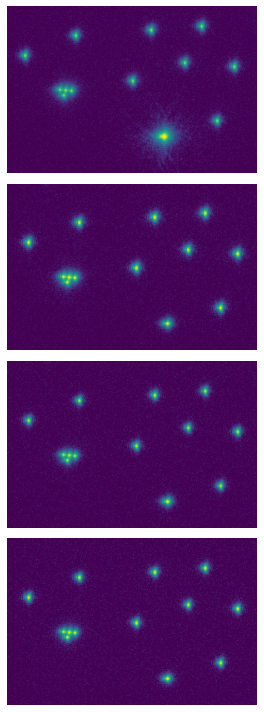

In [21]:
def thumbnails():
    XY = slice(200, 400), slice(3900, 3600, -1)
    fig, axes = plt.subplots(4, 1, figsize=(4, 10))
    for (ax,D) in zip(axes, (seriesAp, seriesBp, seriesCp, seriesDp)):
        ax.imshow(D[XY], origin='lower')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('etc-thumbnails.png')
    
thumbnails()

## ETC Fiber SkyCam Locations

In [22]:
SKY_CALIB = pathlib.Path('/global/cfs/cdirs/desi/cmx/sky/calib/SKY_calib.fits')

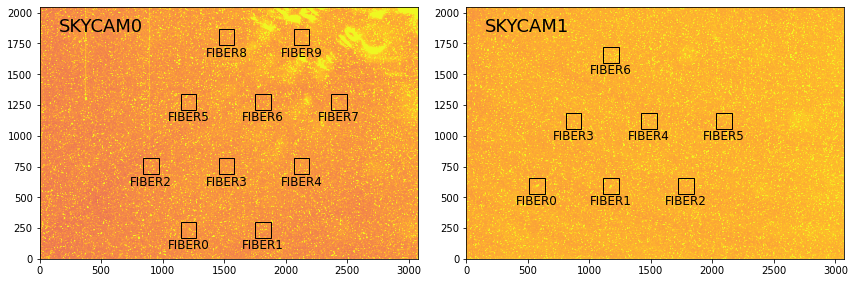

In [62]:
def plot_skycam_spots(night=20211025, expid=106015, frame=0, save=None):
    
    names, slices, masks, spots, calibs = desietc.sky.load_calib_data(SKY_CALIB)

    exptag = str(expid).zfill(8)
    exp_path = DATA / str(night) / exptag
    sky_path = exp_path / f'sky-{exptag}.fits.fz'
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for camera, ax in zip(names, axes):
        raw = fitsio.read(str(sky_path), ext=camera)[frame]
        z = np.arcsinh(raw)
        vmin, vmax = np.percentile(z, (0, 95))
        ax.imshow(z, vmin=vmin, vmax=vmax, cmap='plasma')
        ny, nx = raw.shape
        for (fiber, (y, x)) in zip(names[camera], slices[camera]):
            ax.add_artist(plt.Rectangle((x.start, y.start), x.stop-x.start, y.stop-y.start, fc='none', ec='k'))
            ax.text(0.5 * (x.start + x.stop), y.start - 10, fiber, ha='center', va='top', fontsize=12)
        ax.set(xlim=(0, nx), ylim=(0, ny))
        ax.text(0.05, 0.9, camera, transform=ax.transAxes, ha='left', fontsize=18)

    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_skycam_spots(save='SkyCamRaw.png')

Record what we know about the mapping of focalplane locations to skycam CCD locations:

In [24]:
skycam_map = {
    # SKYCAM0
    461 : (0, 5),  # SKYCAMn, FIBERj (-1 means unknown fiber)
    1501: (0, 9),
    2461: (0, 8),
    3461: (0, 6),
    5501: (0, -1),
    6461: (0, 2),
    7461: (0, 7),
    8461: (0, -1),
    8501: (0, -1),
    9461: (0, 0),
    # SKYCAM1
    501: (1, -1),
    1461: (1, -1),
    2501: (1, -1),
    3501: (1, -1),
    5461: (1, -1),
    7501: (1, -1),
    9501: (1, -1),
}

## Mapping Tiles

Exposures 130554-130557 and 130563 on 20220416 are 5 BACKUP tiles at low Galactic latitude where some fraction of ETC fibers should be landing near stars.  Use these to confirm and complete the map.

In [25]:
SKY = desietc.sky.SkyCamera(calib_name=SKY_CALIB)

In [55]:
SKY.calibs

defaultdict(list,
            {'SKYCAM0': [22.1135556647595,
              1.68631261923494,
              23.2570812462159,
              24.2286516112689,
              24.8165214693758,
              31.886,
              18.8467751602054,
              19.9271324704863,
              27.9764147730336,
              13.7109333215805],
             'SKYCAM1': [25.7991909856535,
              26.8717762412209,
              27.6612814900252,
              26.4697953870875,
              25.8081687693613,
              9.0663345025906,
              25.9233586062783]})

In [26]:
def get_sky_fibers(night, expid):
    exptag = str(expid).zfill(8)
    exp_path = DATA / str(night) / exptag
    sky_path = exp_path / f'sky-{exptag}.fits.fz'
    
    fibers = None
    for k, camera in enumerate(SKY.sky_names):
        calib = np.ones(10)
        calib[:len(SKY.calibs[camera])] = SKY.calibs[camera]
        meta = fitsio.read(str(sky_path), ext=camera+'T')
        frames = fitsio.read(str(sky_path), ext=camera)
        if fibers is None:
            fibers = np.zeros((2, 10, len(frames)))
        for i, frame in enumerate(frames):
            flux, dflux = SKY.setraw(frame, camera)
            fibers[k,:,i] = SKY.flux / calib * desietc.sky.fiber_mask[k] / meta['EXPTIME'][i]
    return fibers

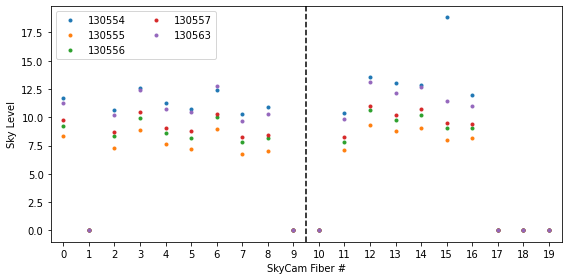

In [27]:
def process_backup_tiles(expids=(130554,130555,130556,130557,130563), night=20220416):
    
    nexp = len(expids)
    backup = np.zeros((2, 10, nexp))
    for i, expid in enumerate(expids):
        fibers = get_sky_fibers(night, expid)
        backup[:,:,i] = np.mean(fibers, axis=2)

    fig, ax = plt.subplots(figsize=(8, 4))
    for i, expid in enumerate(expids):
        ax.plot(backup[:,:,i].reshape(-1), '.', label=f'{expid}')
    ax.legend(loc='upper left', ncol=2)
    ax.set(xlabel='SkyCam Fiber #', xlim=(-0.5, 19.5), ylabel='Sky Level', ylim=(-1, None), xticks=np.arange(20))
    ax.axvline(9.5, c='k', ls='--')
    plt.tight_layout()
    plt.savefig('backup_sky_fibers.jpg')

process_backup_tiles()

## ETC Fiber Focal-Plane Locations

In [28]:
metrology = desimeter.io.load_metrology()

In [29]:
def fit_spots(night=20220317, expid=126529):

    ftag = str(expid).zfill(8)
    file = DATA / '20220317' / ftag / f'fvc-{ftag}.fits.fz'
    assert file.exists()
    # Use desimeter to find the back-illuminated spots.
    spots = desimeter.processfvc.process_fvc(str(file), use_subprocess=False)    
    # Select ETC fibers.
    sel = np.isin(spots['LOCATION'] % 1000, (461, 501))
    etc = spots[sel][['LOCATION','XPIX','YPIX','XERR','YERR','X_FP','Y_FP','COUNTS']]
    print(f'Found {len(etc)} ETC fibers in expid {expid}')
    return etc

In [30]:
# Omit first exposure without fiducials
expids = list(range(126517, 126527)) + list(range(126529, 126539)) + list(range(126539, 126549)) + list(range(126549, 126559))

In [32]:
# Output from this loop is very verbose unless cached results are found
for expid in expids:
    etc = fit_spots(expid=expid)
    etc.write(f'etc-{expid}.csv', overwrite=True)

using previously processed /tmp/fvc-00126517.csv
Found 16 ETC fibers in expid 126517
using previously processed /tmp/fvc-00126518.csv
Found 16 ETC fibers in expid 126518
using previously processed /tmp/fvc-00126519.csv
Found 16 ETC fibers in expid 126519
using previously processed /tmp/fvc-00126520.csv
Found 16 ETC fibers in expid 126520
using previously processed /tmp/fvc-00126521.csv
Found 16 ETC fibers in expid 126521
using previously processed /tmp/fvc-00126522.csv
Found 16 ETC fibers in expid 126522
using previously processed /tmp/fvc-00126523.csv
Found 16 ETC fibers in expid 126523
using previously processed /tmp/fvc-00126524.csv
Found 16 ETC fibers in expid 126524
using previously processed /tmp/fvc-00126525.csv
Found 16 ETC fibers in expid 126525
using previously processed /tmp/fvc-00126526.csv
Found 16 ETC fibers in expid 126526
using previously processed /tmp/fvc-00126529.csv
Found 15 ETC fibers in expid 126529
using previously processed /tmp/fvc-00126530.csv
Found 15 ETC fib

Read index table for ETC fibers generated from [here](https://observablehq.com/@dkirkby/desi-fp-index):

In [33]:
ETCindex = pd.read_csv('ETC-index.csv')
ETCindex['LOCATION'] = ETCindex.PTL_LOC * 1000 + ETCindex.DEV_LOC

In [34]:
def combine():
    mask = np.zeros((10,2,40), bool)
    counts = np.zeros((10,2,40))
    xfp = np.zeros((10,2,40))
    yfp = np.zeros((10,2,40))
    err = np.zeros((10,2,40))
    for i,expid in enumerate(expids):
        data = pd.read_csv(f'etc-{expid}.csv')
        for j, loc in enumerate((461, 501)):
            sel = data.LOCATION % 1000 == loc
            ptl = data.LOCATION[sel] // 1000
            mask[ptl,j,i] = True
            counts[ptl,j,i] = data.COUNTS[sel]
            xfp[ptl,j,i] = data.X_FP[sel]
            yfp[ptl,j,i] = data.Y_FP[sel]
            err[ptl,j,i] = np.hypot(data.XERR[sel], data.YERR[sel])

    # Get subset of fibers that are always found
    always = np.all(mask, axis=2)

    # Normalize the counts to the mean counts of this subset in each exposure.
    norm = np.mean(counts[always], axis=0)
    counts /= norm

    # Calculate weighted mean quantities over exposures.
    wgts = np.divide(1., err, out=np.zeros_like(err), where=err>0)
    wsum = wgts.sum(axis=2)
    wsuminv = np.divide(1., wsum, out=np.zeros_like(wsum), where=wsum>0)

    transmit = np.sum(wgts * counts, axis=2) * wsuminv
    xfocal = np.sum(wgts * xfp, axis=2) * wsuminv
    yfocal = np.sum(wgts * yfp, axis=2) * wsuminv
    xfocal[transmit == 0] = np.nan
    yfocal[transmit == 0] = np.nan

    out = pd.DataFrame(ETCindex[['DEV_ID', 'LOCATION']])
    out.sort_values(by='LOCATION', ignore_index=True, inplace=True)

    out['XMIT'] = transmit.reshape(-1)
    out['X_FP'] = xfocal.reshape(-1)
    out['Y_FP'] = yfocal.reshape(-1)
    
    out['SKYCAM'] = -1
    out['SKYCAM_IDX'] = -1
    for i, row in out.iterrows():
        loc = row.LOCATION
        if loc in skycam_map:
            cam,fib = skycam_map[loc]
            out.loc[i, 'SKYCAM'] = cam
            out.loc[i, 'SKYCAM_IDX'] = fib

    return out

ETCfibers = combine()

## Compare with Offline Snapshot

What values are currently in the [daily snapshots](https://data.desi.lbl.gov/desi/engineering/focalplane/calibration/) for ETC fibers?

In [37]:
def get_snapshot(night):
    DIR = DESI / 'engineering' / 'focalplane' / 'calibration'
    files = sorted(DIR.glob(str(night) + 'T*.ecsv'))
    if len(files) == 0:
        print(f'No snapshot found for {night}')
    dump = astropy.table.Table.read(files[0])
    ETCdump = dump[np.isin(dump['DEVICE_LOC'], (461, 501))]
    ETCdump['LOCATION'] = ETCdump['PETAL_LOC'] * 1000 + ETCdump['DEVICE_LOC']
    ETCdump.sort('LOCATION')
    return ETCdump #[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']]

In [38]:
dump_before = get_snapshot(20220320)

Verify that the ETC info was constant before the 20220321 update:

In [39]:
np.all(
    get_snapshot(20220201)[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']] ==
    dump_before[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']])

True

In [40]:
dump_after = get_snapshot(20220322)

## Convert FP XY to Angles TP

Use desimeter to convert the measured FP locations to internal angles that we can manually load into the moves DB:

In [41]:
def set_angles(T=ETCfibers, CALIB=dump_before):
    
    POS_T = np.zeros(len(T))
    POS_P = np.zeros(len(T))
    
    for petal_loc in range(10):
        tsel = T['LOCATION'] // 1000 == petal_loc
        tloc = np.asarray(T['LOCATION'][tsel] % 1000)
        # Convert from FP to flat coords
        xptl, yptl, _ = desimeter.transform.ptl2fp.fp2ptl(
            petal_loc, T['X_FP'][tsel], T['Y_FP'][tsel])
        xflat, yflat = desimeter.transform.pos2ptl.ptl2flat(xptl, yptl)
        # Lookup calibrations for this petal.
        csel = CALIB['PETAL_LOC'] == petal_loc
        cloc = np.asarray(CALIB['DEVICE_LOC'][csel])
        sorter = np.argsort(cloc)
        idx = sorter[np.searchsorted(cloc, tloc, sorter=sorter)]
        assert np.all(cloc[idx] == tloc)
        x0 = CALIB['OFFSET_X'][csel][idx]; y0 = CALIB['OFFSET_Y'][csel][idx]
        r1 = CALIB['LENGTH_R1'][csel][idx]; r2 = CALIB['LENGTH_R2'][csel][idx]
        T0 = CALIB['OFFSET_T'][csel][idx]; P0 = CALIB['OFFSET_P'][csel][idx]
        DT = CALIB['PHYSICAL_RANGE_T'][idx]; DP = CALIB['PHYSICAL_RANGE_P'][idx]
        # Convert from flat coords to angles
        xloc = desimeter.transform.pos2ptl.flat2loc(xflat, x0)
        yloc = desimeter.transform.pos2ptl.flat2loc(yflat, y0)
        Text, Pext, unreachable = desimeter.transform.pos2ptl.loc2ext(xloc, yloc, r1, r2, T0, P0)
        assert not np.any(unreachable)
        POS_T[tsel] = desimeter.transform.pos2ptl.ext2int(Text, T0)
        POS_P[tsel] = desimeter.transform.pos2ptl.ext2int(Pext, P0)

    T['T_INT'] = POS_T
    T['P_INT'] = POS_P        
    T.to_csv('ETC-fibers.csv', index=False)

    return T

ETCfibers = set_angles()

In [42]:
ETCfibers

,DEV_ID,LOCATION,XMIT,X_FP,Y_FP,SKYCAM,SKYCAM_IDX,T_INT,P_INT
0,M04529,461,1.235704,-95.709952,-401.759363,0,5,-43.056783,131.298508
1,M02956,501,1.061377,-42.353894,-408.140512,1,-1,-78.761299,134.107401
2,M04133,1461,1.066570,158.043823,-377.760307,1,-1,65.424464,143.842128
3,M03156,1501,0.618033,205.824726,-352.705955,0,9,-2.550532,174.042067
4,M04283,2461,1.073602,350.093825,-214.311212,0,8,62.222211,174.616150
5,M05607,2501,0.909667,373.284872,-164.374550,1,-1,88.102392,172.621617
6,M04478,3461,0.965651,409.205717,32.338761,0,6,85.083722,175.476436
7,M03990,3501,1.007975,398.629895,86.364828,1,-1,106.039638,173.120921
8,M01190,4461,0.000000,NaN,NaN,-1,-1,NaN,NaN
9,M02792,4501,0.000000,NaN,NaN,-1,-1,NaN,NaN


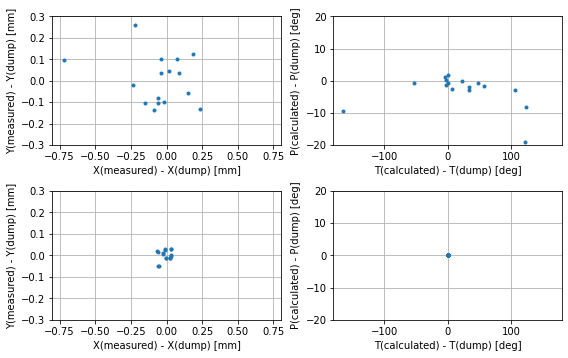

In [43]:
def compare():
    
    before = dump_before[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']].to_pandas(index='POS_ID').join(ETCfibers.set_index('DEV_ID'))
    after = dump_after[['POS_ID', 'OBS_X','OBS_Y', 'POS_T', 'POS_P']].to_pandas(index='POS_ID').join(ETCfibers.set_index('DEV_ID'))

    fig, axes = plt.subplots(2, 2, figsize=(8, 5))

    for ((left,right), both) in zip(axes, (before, after)):
        
        ok = np.isfinite(both.X_FP)

        left.plot(both.X_FP[ok] - both.OBS_X[ok], both.Y_FP[ok] - both.OBS_Y[ok], '.')
        left.set_xlabel('X(measured) - X(dump) [mm]')
        left.set_ylabel('Y(measured) - Y(dump) [mm]')
        left.set_xlim(-0.8, 0.8)
        left.set_ylim(-0.3, 0.3)
        left.grid()

        right.plot(np.fmod(both.T_INT[ok] - both.POS_T[ok] + 180, 360) - 180, both.P_INT[ok] - both.POS_P[ok], '.')
        right.set_xlabel('T(calculated) - T(dump) [deg]')
        right.set_ylabel('P(calculated) - P(dump) [deg]')
        right.set_xlim(-180, 180)
        right.set_ylim(-20, 20)
        right.grid()
        
    plt.tight_layout()
    plt.savefig('etc-compare.png')

compare()

In [44]:
def updateDB():
    print('POS_ID,POS_T,POS_P,COMMIT_POS_T,COMMIT_POS_P')
    for i, row in ETCfibers.dropna().iterrows():
        print(f'{row.DEV_ID},{np.round(row.T_INT,3)},{np.round(row.P_INT,3)},True,True')

updateDB()

POS_ID,POS_T,POS_P,COMMIT_POS_T,COMMIT_POS_P
M04529,-43.057,131.299,True,True
M02956,-78.761,134.107,True,True
M04133,65.424,143.842,True,True
M03156,-2.551,174.042,True,True
M04283,62.222,174.616,True,True
M05607,88.102,172.622,True,True
M04478,85.084,175.476,True,True
M03990,106.04,173.121,True,True
M01727,20.065,144.582,True,True
M06214,-87.115,119.418,True,True
M06009,3.269,166.205,True,True
M03943,19.538,177.616,True,True
M03159,174.646,177.558,True,True
M02732,-136.968,174.826,True,True
M04583,18.114,178.68,True,True
M05070,78.086,143.127,True,True


## Plot ETC Fiber Locations and Transmissions

In [45]:
#ETCfibers = pd.read_csv('ETC-fibers.csv', index_col='LOCATION')

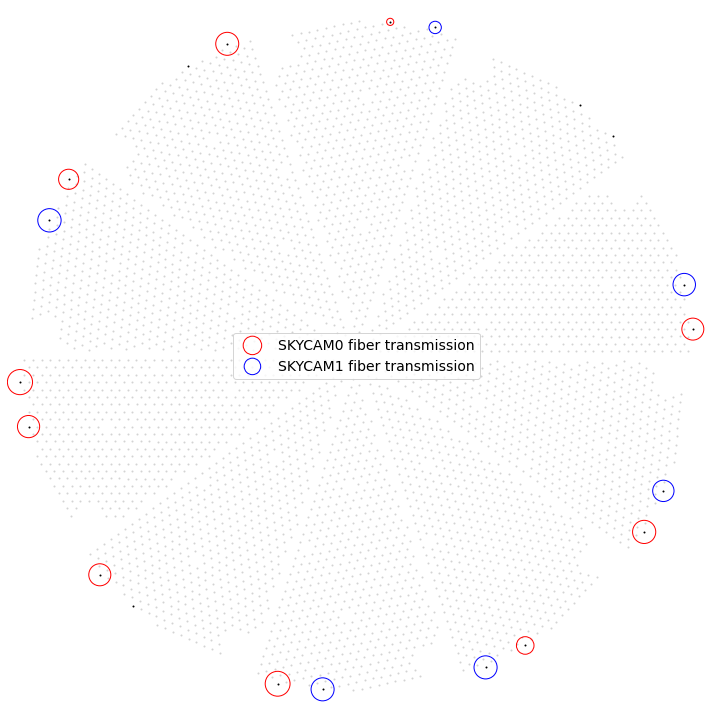

In [52]:
def plot_etc_focalplane(r=500, lim=425, save=None):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect(1)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.axis('off')

    POS = fpoffline.array.DeviceArray(POS=True, ETC=False)
    x, y = POS.xy(slice(None))
    ax.scatter(x, y, lw=0, s=4, c='lightgray')

    ETC = fpoffline.array.DeviceArray(POS=False, ETC=True)
    x, y = ETC.xy(slice(None))
    ax.scatter(x, y, lw=0, s=4, c='k')
    
    for skycam, ec in zip((0, 1),('r','b')):
        sel = ETCfibers.SKYCAM == skycam
        fibers = ETCfibers[sel]
        locs = fibers.index.to_numpy()
        x, y = ETC.xy(locs)
        xmit = fibers.XMIT.to_numpy()
        ax.scatter(x, y, lw=1, s=r*xmit, fc='none', ec=ec, label=f'SKYCAM{skycam} fiber transmission')
    ax.legend(loc='center', prop=dict(size=14))
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

plot_etc_focalplane(save='SkyCamXmit.png')